## Breakout with DQN

In [2]:
import gym
import numpy as np
import torch
from torch import nn
from PIL import Image
import random
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
env = gym.make('Breakout-v4')
env.reset();

In [4]:
env.action_space

Discrete(4)

In [5]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

### let's see the game being played by a random agent

this might take a while, if you want to see enough random games

In [6]:
state = env.reset()

games_played = 0
screens = [state]

for step_i in range(1000):

    next_state, reward , done, env_info = env.step( env.action_space.sample() ) 
    
    
    
    screens.append(next_state)
    
    if done:
        games_played+=1
        state = env.reset()
    else:
        state = next_state

print('played ',games_played,' games')

played  3  games


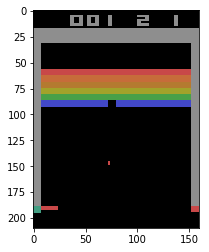

In [7]:
fig = plt.figure()
ax = plt.axes()

im = ax.imshow(screens[0])

def init():
    im.set_data(screens[0])
    return [im]


def animate(i):
    im.set_data(screens[i])
    return [im]


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

anim.save('breakout_animation.mp4', fps=120, extra_args=['-vcodec', 'libx264'])

#plt.show()

In [8]:
HTML(anim.to_html5_video())

## we want to do a bit of preprocessing to our images

we don't really need all the colors and full resolution image, 
make it grayscale and resize

In [10]:
class StatePrep(object):
    """ Preproces the state. """
    def __init__(self, size):
        
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Lambda(lambda x: x.convert('L')),
            T.Resize((size,size)),
            T.ToTensor()])

    def run(self, s):
        s = s[35:205] # crop
        s = s[:,7:153]

        s = self.transform(s)
        s[s > 0] = 1
        return s.unsqueeze(0)

#we create this object and tell it what size to resize our images to
prep = StatePrep(84)

### lets look at an example image and preprocessed image

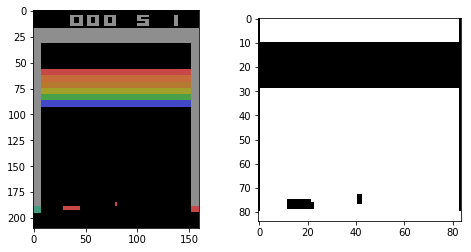

In [11]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

idx = 23
sprime = prep.run(screens[idx])

ax[0].imshow(screens[idx])
ax[1].imshow(-sprime[0][0],cmap='gray')

plt.show()

## the state we deal with is a collection of 4 frames. while the states given from the environment are a single frame. 

let's create functions to initialize a state with 4 frames, and to add a single frame to an existing state

In [12]:
def InitialState(state):
    return torch.cat([prep.run(state)] * 4, 1)

def AddNextState(state,next_state):
    return torch.cat([state.narrow(1, 1, 3), prep.run(next_state)], 1)

## In the stage where we generate games, we store the (state,action,reward, next state) information in a memory buffer

let's define the class for that memory buffer

In [13]:
class ReplayMemory(object):
    """ Facilitates memory replay. """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.idx = 0

    def push(self, m):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.idx] = m
        self.idx = (self.idx + 1) % self.capacity

    def sample(self, bsz):
        batch = random.sample(self.memory, bsz)
        return map(lambda x: torch.cat(x, 0), zip(*batch))

## Now we define our agent neural net

In [14]:
class QNet(nn.Module):
    def __init__(self, nA):
        super(QNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, nA)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        return self.fc2(x)

## define a function to choose an action based on neural network output and epsilon parameter

In [15]:
def ChooseAction(net,n_actions,state,eps):
    p = np.array([eps/n_actions]*4)
    
    q, arg_q = net(state).data.cpu().max(1) # choose max Q and matching action
    
    p[arg_q.item()]+= 1-eps
    
    action = np.random.choice(np.arange(n_actions),p=p)
    
    next_state, reward, done, _ = env.step(action)
    
    next_state = AddNextState(state,next_state)
    
    return next_state, reward, action, done
    

In [16]:
### hyperparameters

mem_capacity = 1000000
eps_min = 0.1
eps_decay_window = 1000000
mem_init_size = 50000
max_episodes = 10000
sync_period = 10000
learn_freq = 4
batch_size = 32
gamma = 0.99

### let's initialize our objects

In [17]:
env = gym.make('Breakout-v4')
state = env.reset()
state = InitialState(state)

n_actions = env.action_space.n

mem = ReplayMemory(mem_capacity)

Qnet = QNet(n_actions)
Tnet = QNet(n_actions)

opt = torch.optim.RMSprop(Qnet.parameters(),
        lr=0.00025, eps=0.001, alpha=0.95)
crit = nn.MSELoss()

Qnet.train()
Tnet.eval()

eps = 1
eps_delta = (eps - eps_min) / eps_decay_window

# fill the memory buffer with random games

In [18]:
for _ in range(mem_init_size):
    next_state, reward, action, done = ChooseAction(Qnet,n_actions,state,eps)
    
    mem.push((state, torch.LongTensor([int(action)]),
                torch.Tensor([reward]), next_state, torch.Tensor([done])))
    
    if done:
        state = env.reset()
        state = InitialState(state)
    else:
        state = next_state

## start the training / generating loop

we won't actually bother to train this, you will see how it works in practice in the homework, but much faster

In [81]:
t = 0

episode_rewards = []

for episode_i in range(max_episodes):
    
    if episode_i % 10 == 0:
        print('episode ',episode_i+1)
    
    state = env.reset()
    state = InitialState(state)
    done = False
    ep_len = 0
    
    episode_rewards.append(0)
    
    while not done:
        if t % sync_period == 0:
            Tnet.load_state_dict(Qnet.state_dict())
        
        
        #adjust epsilon
        
        cur_eps = max(eps_min, eps - eps_delta * t)
        
        # play a step, save in memory buffer
        
        next_state, reward, action, done = ChooseAction(Qnet,n_actions,state,cur_eps)
        
        episode_rewards[-1]+=reward
        
        mem.push((state, torch.LongTensor([int(action)]),
                torch.Tensor([reward]), next_state, torch.Tensor([done])))
        if done:
            state = env.reset()
            state = InitialState(state)
        else:
            state = next_state
            
        t += 1
        ep_len += 1
        
        #every n steps, perform a training step, on a minibatch sampled from the memory buffer
        
        if ep_len % learn_freq == 0:
            opt.zero_grad()
            
            bs, ba, br, bns, bdone = mem.sample(batch_size)
            
            bq = Qnet(bs).gather(1, ba.unsqueeze(1)).squeeze(1)
            
            bnq = Tnet(bns).detach().max(1)[0] * gamma * (1 - bdone)
            
            loss = crit(bq, br + bnq)
            
            loss.backward()
            
            opt.step()

episode  1
episode  11
episode  21
episode  31
episode  41
episode  51
episode  61
episode  71
episode  81
episode  91
